In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))

import config
from feat_util import get_train_test_from_df, get_test_from_df
from write_audio import write_audio_for_df
from evaluate import get_results, plot_confusion_matrix_multiclass, compute_plot_roc_multiclass

from sklearn.utils import shuffle
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
# Extra imports
import feat_util
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
library = 'Keras'

if library == 'PyTorch':
    from runTorch import train_model, load_model, evaluate_model
elif library == 'Keras':
    from tensorflow import keras
    import config_keras
    from runKeras import train_model, load_model, evaluate_model
else:
    print('Library:', library, 'not supported. Please add your own code for support of that framework.')

C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ikiskin\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ikiskin

In [4]:
# Select IHI Tanzania cup data to use for multi-species classification

df = pd.read_csv(config.data_df)
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [5]:
# Select list of classes with sufficient samples for significant analysis. Ordered with similar groups in adjacent classes.

classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus']

# Create features (only re-run if not loading from pickle)

In [6]:
import collections
species_dict = collections.OrderedDict()
species_recordings = collections.OrderedDict()
for species in classes:
    # Number of total audio clips per species (includes repeats from same filename)
    species_recordings[species] = len(pd.unique(df_all[df_all.species==species].name)) # Number of unique audio recordings (and hence mosquitoes)
    species_dict[species] = sum(df_all[df_all.species==species].length)

In [125]:
len(y_train)

1723

In [7]:
# Divide recordings into train and test, with recording shuffling fixed by random_state
train_fraction = 0.75
train_recordings = {}
test_recordings = {}

for i in range(len(classes)):
    n_train = int(species_recordings[classes[i]] * train_fraction)
    n_test = species_recordings[classes[i]] - n_train
    print(classes[i], n_train, n_test)
    df_class = df_all[df_all.species == classes[i]]
    # !!!I think it is probably best to shuffle these to mimic W but need to make sure each ID of mosquito is unique per recording
    train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=42)[:n_train]  
    test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=42)[n_train:]

an arabiensis 385 129
culex pipiens complex 252 84
ae aegypti 36 13
an funestus ss 186 62
an squamosus 68 23
an coustani 37 13
ma uniformis 57 19
ma africanus 28 10


In [38]:
def get_feat_multispecies(df_all, label_recordings_dict, data_dir, rate, n_feat):
    '''Extract features for multi-class species classification.'''
    X = []
    y = []

    for class_label in tqdm(label_recordings_dict.keys(), position=0, leave=True): # Loop over classes
        print('Extracting features for class:', class_label)
        for i in label_recordings_dict[class_label]: # Loop over recordings in class
            df_match = df_all[df_all.name == i]
            for idx, row in df_match.iterrows(): # Loop over clips in recording
                _, file_format = os.path.splitext(row['name'])
                filename = os.path.join(data_dir, str(row['id']) + file_format)
                signal, rate = librosa.load(filename, sr=rate)
                feat = librosa.feature.melspectrogram(signal, sr=rate, n_mels=n_feat) 
#                 feat = librosa.feature.mfcc(y=signal, sr=rate, n_mfcc=n_feat)
                feat = librosa.power_to_db(feat, ref=np.max)
                if config.norm_per_sample:
                    feat = (feat-np.mean(feat))/np.std(feat)                
                X.append(feat)
                y.append(class_label)
    return X, y

In [39]:
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Extracting features for class: 0


 12%|██████████▍                                                                        | 1/8 [01:49<12:44, 109.23s/it]

Extracting features for class: 1


 25%|█████████████████████                                                               | 2/8 [02:47<07:54, 79.14s/it]

Extracting features for class: 2


 38%|███████████████████████████████▌                                                    | 3/8 [02:57<03:58, 47.63s/it]

Extracting features for class: 3


 50%|██████████████████████████████████████████                                          | 4/8 [03:49<03:18, 49.54s/it]

Extracting features for class: 4


 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:07<01:53, 37.93s/it]

Extracting features for class: 5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [04:17<00:56, 28.43s/it]

Extracting features for class: 6


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [04:27<00:22, 22.50s/it]

Extracting features for class: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:34<00:00, 34.34s/it]


In [40]:
# Extract feats, expected runtime ~5 mins
X_test, y_test = get_feat_multispecies(df_all, test_recordings, config.data_dir, config.rate, config.n_feat)
# Extract feats, expected runtime ~14 mins
X_train, y_train = get_feat_multispecies(df_all, train_recordings, config.data_dir, config.rate, config.n_feat)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Extracting features for class: 0


 12%|██████████▍                                                                        | 1/8 [05:26<38:02, 326.00s/it]

Extracting features for class: 1


 25%|████████████████████▊                                                              | 2/8 [08:38<24:43, 247.24s/it]

Extracting features for class: 2


 38%|███████████████████████████████▏                                                   | 3/8 [09:07<12:19, 147.80s/it]

Extracting features for class: 3


 50%|█████████████████████████████████████████▌                                         | 4/8 [11:47<10:09, 152.48s/it]

Extracting features for class: 4


 62%|███████████████████████████████████████████████████▉                               | 5/8 [12:33<05:42, 114.02s/it]

Extracting features for class: 5


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [12:57<02:47, 83.57s/it]

Extracting features for class: 6


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [13:35<01:08, 68.83s/it]

Extracting features for class: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [13:52<00:00, 104.02s/it]


# Save features to pickle

In [41]:
# Save feature output to pickle

import pickle
pickle_name_train = 'log_mel_feat_shuffle_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_test_norm_'+str(config.norm_per_sample)+'.pickle'

log_mel_feat_train = {"X_train":X_train, "y_train":y_train}
log_mel_feat_test = {"X_test":X_test, "y_test":y_test}


dir_out = '../outputs/features/multi-species/humbugdb'
with open(os.path.join(dir_out, pickle_name_train), 'wb') as f:
    pickle.dump(log_mel_feat_train, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_train))
    
with open(os.path.join(dir_out, pickle_name_test), 'wb') as f:
    pickle.dump(log_mel_feat_test, f, protocol=4)
    print('Saved features to:', os.path.join(dir_out, pickle_name_test))   

Saved features to: ../outputs/features/multi-species/humbugdb\for_diff_log_mel_feat_shuffle_train_norm_True.pickle
Saved features to: ../outputs/features/multi-species/humbugdb\for_diff_log_mel_feat_shuffle_test_norm_True.pickle


# Load pickled features

In [8]:
# Load pickle

import pickle
dir_out = '../outputs/features/multi-species/humbugdb'
pickle_name_train = 'log_mel_feat_shuffle_train_norm_'+str(config.norm_per_sample)+'.pickle'
pickle_name_test = 'log_mel_feat_shuffle_test_norm_'+str(config.norm_per_sample)+'.pickle'


with open(os.path.join(dir_out, pickle_name_train), 'rb') as input_file:
    log_mel_feat_train = pickle.load(input_file)
    
with open(os.path.join(dir_out, pickle_name_test), 'rb') as input_file:
    log_mel_feat_test = pickle.load(input_file)
    
X_train = log_mel_feat_train["X_train"]
y_train = log_mel_feat_train["y_train"]
X_test = log_mel_feat_test["X_test"]
y_test = log_mel_feat_test["y_test"]

In [9]:
# Reshape features to be used with CNN (Keras or PyTorch)

X_train_CNN, y_train_CNN = feat_util.reshape_feat(X_train, y_train, config.win_size, config.step_size)
X_test_CNN, y_test_CNN = feat_util.reshape_feat(X_test, y_test, config.win_size, config.win_size)

(array([31397., 17163.,  2707., 15981.,  4299.,  2223.,  3575.,  1400.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

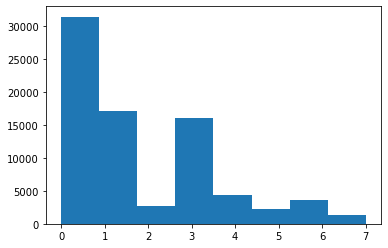

In [49]:
# View class distribution of windows in y label space
plt.hist(y_train_CNN, bins=8)

# Model definition and optimisation
Current model here is identical to the model used in paper for previous results with binary mosquito/noise detection. Acts as good baseline for further work.

## ##TODO: implement PyTorch versions for multiclass

In [10]:
# Define model: left here for now for optimising

import tensorflow as tf
import config_keras
config_keras.epochs = 80
config_keras.batch_size = 128
import config
from keras.utils import to_categorical
# Deep learning
# Keras-related imports
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
# K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint, RemoteMonitor, EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
import os
from datetime import datetime

def train_model_multiclass(X_train, y_train, class_weight=None, X_val=None, y_val=None, start_from=None):


	y_train = tf.keras.utils.to_categorical(y_train)
	if y_val is not None:
		y_val = tf.keras.utils.to_categorical(y_val)


	################################ CONVOLUTIONAL NEURAL NETWORK ################################
	## NN parameters
# 	class_weight = {0: 1.,
# 	                1: 1.,
# 	                }
	input_shape = (1, X_train.shape[2], X_train.shape[-1])

	# BNN parameters
	dropout=config_keras.dropout  # change to 0.05
	# Regularise
	tau = config_keras.tau
	lengthscale = config_keras.lengthscale
	reg = lengthscale**2 * (1 - dropout) / (2. * len(X_train) * tau)

	W_regularizer=l2(reg)  # regularisation used in layers

	model = Sequential()
	n_dense = 128
	nb_classes = y_train.shape[1]
	# number of convolutional filters
	nb_conv_filters = 32
	# num_hidden = 236
	nb_conv_filters_2 = 64
	convout1 = Activation('relu')
	convout2 = Activation('relu')

	model.add(Conv2D(nb_conv_filters, kernel_size = (3,3),
	     activation = 'relu', padding = 'valid', strides = 1,
	     input_shape = input_shape))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Lambda(lambda x: K.dropout(x,level=dropout)))


	model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
	     activation = 'relu', padding = 'valid'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
	model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
	     activation = 'relu', padding = 'valid'))
	# model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

	

	# # model.add(Dropout(0.2))
	model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
	     activation = 'relu', padding = 'valid'))
	model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

	# model.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
	#      activation = 'relu', padding = 'valid'))
	# model.add(Lambda(lambda x: K.dropout(x,level=dropout)))

	model.add(Flatten())
	# # Shared between MLP and CNN:
	model.add(Dense(n_dense, activation='relu'))
	model.add(Lambda(lambda x: K.dropout(x,level=dropout)))


	model.add(Dense(nb_classes, activation='softmax',kernel_regularizer=l2(reg)))
	model.compile(loss='categorical_crossentropy',
	                optimizer='adadelta',
	                metrics=['accuracy'])


	if start_from is not None:
		model = load_model(start_from)
		print('Starting from model', start_from)

    # if checkpoint_name is not None:
    # 	os.path.join(os.path.pardir, 'models', 'keras', checkpoint_name)

	if X_val is None:
		metric = 'accuracy'
		val_data = None
	else:
		metric = 'val_accuracy'
		val_data = (X_val, y_val)

	model_name = 'Win_' + str(config.win_size) + '_Stride_' + str(config.step_size) + '_'
	model_name = model_name + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '-e{epoch:02d}' + metric + '{' + metric + ':.4f}.hdf5'
	# model_name = model_name + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '-e{epoch:02d}.hdf5'
	checkpoint_filepath = os.path.join(config.model_dir, 'keras_Multiclass',  model_name)
	model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,
		monitor=metric,
		mode='max',
		save_best_only=False)

	model.fit(x=X_train, y=y_train, batch_size=config_keras.batch_size, epochs=config_keras.epochs, verbose=1,
		validation_data=val_data,
		shuffle=True, class_weight=class_weight, sample_weight=None, initial_epoch=0,
		steps_per_epoch=None, validation_steps=None, callbacks=[model_checkpoint_callback])


	
	return model

In [11]:
# Compute class weights to weight by inverse of class frequency

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_CNN),
                                                 y_train_CNN)

class_weights = dict(enumerate(class_weights.flatten()))  # Dict to support both older and newer Keras API

In [ ]:
model = train_model_multiclass(X_train_CNN, y_train_CNN, class_weight = class_weights)



Epoch 1/80
78745/78745 [==============================] - 18s 222us/step - loss: 1.4031 - accuracy: 0.4082
Epoch 2/80
78745/78745 [==============================] - 16s 198us/step - loss: 0.9367 - accuracy: 0.5629
Epoch 3/80
78745/78745 [==============================] - 16s 198us/step - loss: 0.7268 - accuracy: 0.6414
Epoch 4/80
78745/78745 [==============================] - 15s 196us/step - loss: 0.6025 - accuracy: 0.6883
Epoch 5/80
77056/78745 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.7192

# Load model from checkpoint

In [5]:
import tensorflow as tf
# Select checkpoint to load model (optional)
# Following filepath used for results on 26/07/
filepath = '../outputs/models/keras_Multiclass/Win_30_Stride_5_2021_07_26_12_59_05-e80accuracy0.9635.hdf5'

model = tf.keras.models.load_model(filepath, custom_objects={"dropout": 0.2})


In [8]:
# Sample predictions from BNN. To save time, when analysing quick configurations, set samples to N=10

BNN_samples = 3
preds_list = []
for i in range(BNN_samples):
    preds_values = model.predict(X_test_CNN)
    preds_list.append(preds_values)

BNN sampled
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1890
           1       0.63      0.62      0.62      1000
           2       0.82      0.51      0.63       175
           3       0.70      0.74      0.72       928
           4       0.46      0.27      0.34       275
           5       0.33      0.09      0.15       159
           6       0.33      0.28      0.31       172
           7       0.31      0.15      0.20       122

    accuracy                           0.65      4721
   macro avg       0.53      0.43      0.46      4721
weighted avg       0.63      0.65      0.63      4721



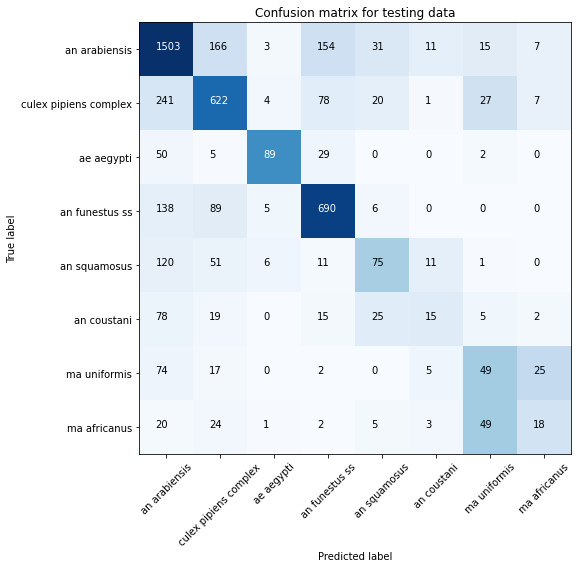

In [11]:
print('BNN sampled')
from sklearn.metrics import classification_report,confusion_matrix

cnf_matrix = confusion_matrix(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1))
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for testing data', classes)
print(classification_report(y_test_CNN, np.argmax(np.mean(preds_list,axis=0), axis=1)))


In [55]:
# debug multi ROC:

y_pred_prob = np.mean(preds_list,axis=0)
y_true = y_test_CNN

In [74]:
from tensorflow.keras.utils import to_categorical

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], thresholds = sklearn.metrics.roc_curve(to_categorical(y_true)[:, i], y_pred_prob[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

In [59]:
classes

['an arabiensis',
 'culex pipiens complex',
 'ae aegypti',
 'an funestus ss',
 'an squamosus',
 'an coustani',
 'ma uniformis',
 'ma africanus']

In [87]:
y_true

array([0, 0, 0, ..., 7, 7, 7])

In [75]:
thresholds

array([1.96146238e+00, 9.61462379e-01, 8.83469999e-01, 8.69187534e-01,
       8.55448246e-01, 8.54588270e-01, 7.25255728e-01, 7.14352369e-01,
       6.76779687e-01, 6.56795204e-01, 6.46736622e-01, 6.45515144e-01,
       6.42261028e-01, 6.24037504e-01, 6.08306825e-01, 6.06340051e-01,
       5.58784425e-01, 5.57717144e-01, 5.51775694e-01, 5.37133098e-01,
       5.15230417e-01, 5.07302642e-01, 4.92125660e-01, 4.89191830e-01,
       4.56470728e-01, 4.54367757e-01, 4.50174183e-01, 4.28305537e-01,
       4.27644581e-01, 4.09228861e-01, 3.72597516e-01, 3.69846582e-01,
       3.50907594e-01, 3.46837878e-01, 3.46021295e-01, 3.45177799e-01,
       3.43485445e-01, 3.27777624e-01, 3.26733738e-01, 2.92330891e-01,
       2.76848197e-01, 2.73620993e-01, 2.54036516e-01, 2.47566104e-01,
       2.46925235e-01, 2.45536193e-01, 2.44745538e-01, 2.36801028e-01,
       2.36261457e-01, 2.26938710e-01, 2.20677719e-01, 2.13085055e-01,
       2.10758835e-01, 2.10121557e-01, 2.05071330e-01, 2.04230458e-01,
      

In [73]:
len(y_pred_prob[:,0])

4721

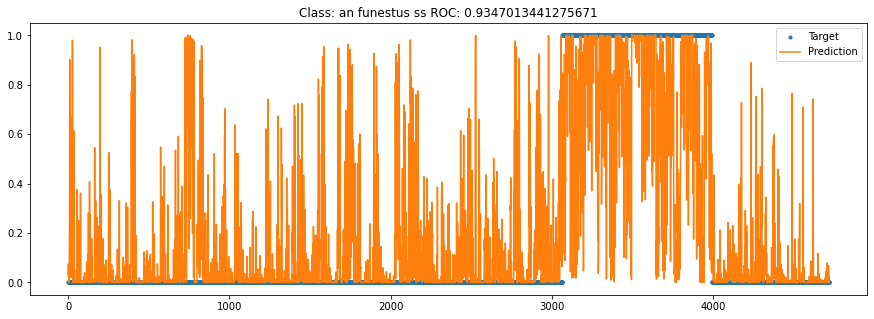

In [112]:
plt.figure(figsize=(15,5))
idx=3
plt.plot(to_categorical(y_true)[:,idx],'.',label='Target')
plt.plot(y_pred_prob[:,idx], label='Prediction')
plt.legend()
plt.title('Class: ' + classes[idx] + ' ROC: ' + str(roc_auc[idx]))
plt.show()

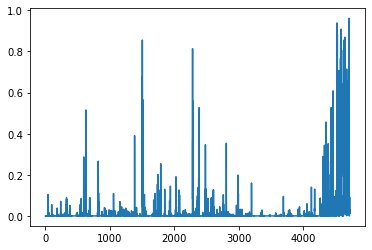

In [84]:
plt.plot(y_pred_prob[:,0])

In [72]:
len(y_test_CNN)

4721

In [61]:
len(fpr[0])

1369

In [62]:
len(fpr[1])

990

In [63]:
len(fpr[2])

152

In [60]:
roc_auc[0]

0.865415963473187

In [58]:
fpr[0]

array([0.        , 0.        , 0.        , ..., 0.97633345, 0.97633345,
       1.        ])

BNN
{0: 0.8478999512203327, 1: 0.8671017199677507, 2: 0.9531883602539124, 3: 0.916001828458958, 4: 0.8440150492782071, 5: 0.8563564474369898, 6: 0.833741890627636, 7: 0.8934764863352332, 'micro': 0.919362669538068}


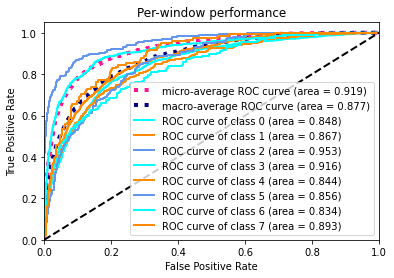

In [13]:
compute_plot_roc_multiclass(y_test_CNN, np.mean(preds_list,axis=0), classes, title='Per-window performance')

# Evaluate performance per recording (extension)

In [227]:
def evaluate_aggregate_predictions(X_test, y_test, model, BNN_samples):
    '''Produce a decision of mosquito type per recording based on taking the mean of predictions over strided features as in 
    feat_util.reshape_feat. By default uses config.win_size and config.step_size as parameters for feature windowing.'''
    preds_aggregated_by_mean = []
    y_aggregated_prediction_by_mean = []
    
    for idx, recording in enumerate(X_test):
        preds_list = []
        X_item, _ = feat_util.reshape_feat([recording], [y_test[idx]], config.win_size, config.step_size)
        for i in range(BNN_samples):
            preds_values = model.predict(X_item)
            preds_list.append(preds_values)
        preds_values = np.mean(preds_list,axis=0)
    #     G_X, U_X, _ = active_BALD(np.log(preds_list), X_item, 8)

        preds_max = np.amax(preds_values, axis=1)
        preds = np.argmax(preds_values, axis=1)
        y_aggregated_prediction_by_mean.append(np.argmax(np.mean(preds_values, axis=0)))
        preds_aggregated_by_mean.append(np.mean(preds_values, axis=0))
    return preds_aggregated_by_mean, y_aggregated_prediction_by_mean

In [228]:
preds_aggregated_by_mean, y_aggregated_prediction_by_mean = evaluate_aggregate_predictions(X_test, y_test, model, 100)

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       200
           1       0.68      0.67      0.67       136
           2       1.00      0.42      0.59        24
           3       0.76      0.79      0.77        94
           4       0.60      0.33      0.43        36
           5       0.43      0.13      0.20        23
           6       0.39      0.43      0.41        30
           7       0.25      0.09      0.13        22

    accuracy                           0.66       565
   macro avg       0.60      0.46      0.49       565
weighted avg       0.65      0.66      0.64       565



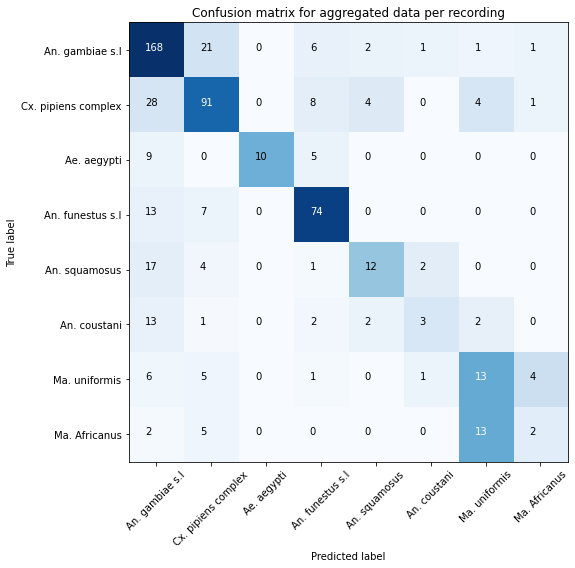

In [229]:
cnf_matrix = confusion_matrix(y_test, y_aggregated_prediction_by_mean)
plot_confusion_matrix_multiclass(cnf_matrix, 'Confusion matrix for aggregated data per recording', classes_target)
print(classification_report(y_test, y_aggregated_prediction_by_mean))

BNN
{0: 0.8787260273972602, 1: 0.8697038255861785, 2: 0.9205175600739371, 3: 0.9499028775353481, 4: 0.9035916824196597, 5: 0.9159313332263757, 6: 0.9117757009345795, 7: 0.9384731290808639, 'micro': 0.9289824687021022}


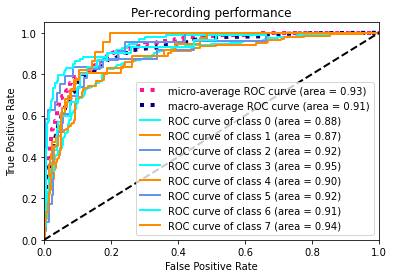

In [245]:
compute_plot_roc_multiclass(y_test,np.array(preds_aggregated_by_mean), classes, title='Per-recording performance')

# Unused leftovers: to be used for further debugging if necessary